In [ ]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/train/train.zip

#Question 1

Text(0.5, 1.0, 'Binary2')

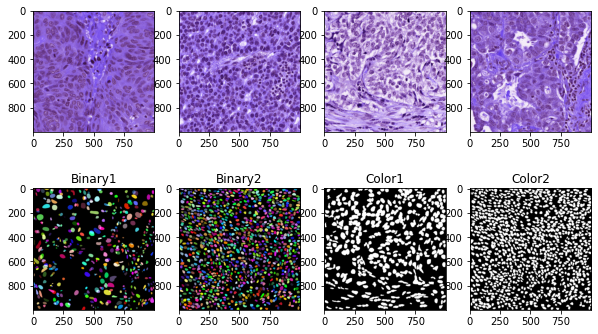

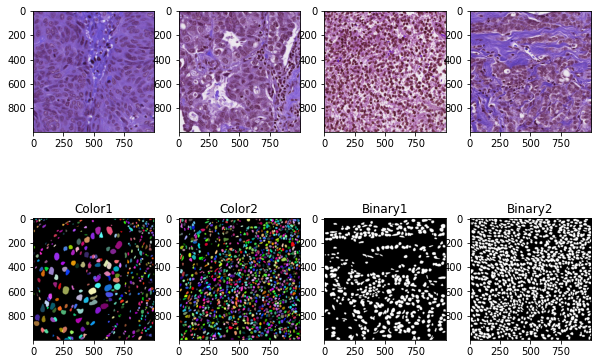

In [ ]:
## a. Training data is in folders Norm-Tissue-Images and Binary-Mask
rows = 2
cols = 4
fig = plt.figure(figsize=(10, 6))
img_train1 = cv2.imread('/content/MoNuSeg-Training-Data/Norm-Tissue-Images/TCGA-18-5592-01Z-00-DX1.png')
img_train2 = cv2.imread('/content/MoNuSeg-Training-Data/Norm-Tissue-Images/TCGA-21-5784-01Z-00-DX1.png')
img_train3 = cv2.imread('/content/MoNuSeg-Training-Data/Norm-Tissue-Images/TCGA-21-5786-01Z-00-DX1.png')
img_train4 = cv2.imread('/content/MoNuSeg-Training-Data/Norm-Tissue-Images/TCGA-38-6178-01Z-00-DX1.png')
mask1 = cv2.imread('/content/MoNuSeg-Training-Data/Color-Mask/TCGA-38-6178-01Z-00-DX1.png')
mask2 = cv2.imread('/content/MoNuSeg-Training-Data/Color-Mask/TCGA-B0-5698-01Z-00-DX1.png')
mask3 = cv2.imread('/content/MoNuSeg-Training-Data/Binary-Mask/TCGA-21-5786-01Z-00-DX1.png')
mask4 = cv2.imread('/content/MoNuSeg-Training-Data/Binary-Mask/TCGA-B0-5698-01Z-00-DX1.png')
fig.add_subplot(rows, cols, 1)
plt.imshow(img_train1)

fig.add_subplot(rows, cols, 2)
plt.imshow(img_train2)
fig.add_subplot(rows, cols, 3)
plt.imshow(img_train3)
fig.add_subplot(rows, cols, 4)
plt.imshow(img_train4)
fig.add_subplot(rows, cols, 5)
plt.imshow(mask1)
plt.title('Binary1')
fig.add_subplot(rows, cols, 6)
plt.imshow(mask2)
plt.title('Binary2')
fig.add_subplot(rows, cols, 7)
plt.imshow(mask3)
plt.title('Color1')
fig.add_subplot(rows, cols, 8)
plt.imshow(mask4)
plt.title('Color2')

## b. Testing data is in folders Tissue-Images and Binary-Mask
rows=2
cols = 4
fig = plt.figure(figsize=(10, 7))
img_test1 = cv2.imread('/content/MoNuSeg-Training-Data/Tissue-Images/TCGA-18-5592-01Z-00-DX1.png')
img_test2 = cv2.imread('/content/MoNuSeg-Training-Data/Tissue-Images/TCGA-38-6178-01Z-00-DX1.png')
img_test3 = cv2.imread('/content/MoNuSeg-Training-Data/Tissue-Images/TCGA-A7-A13E-01Z-00-DX1.png')
img_test4 = cv2.imread('/content/MoNuSeg-Training-Data/Tissue-Images/TCGA-AR-A1AK-01Z-00-DX1.png')
mask1 = cv2.imread('/content/MoNuSeg-Training-Data/Color-Mask/TCGA-E2-A14V-01Z-00-DX1.png')
mask2 = cv2.imread('/content/MoNuSeg-Training-Data/Color-Mask/TCGA-RD-A8N9-01A-01-TS1.png')
mask3 = cv2.imread('/content/MoNuSeg-Training-Data/Binary-Mask/TCGA-AR-A1AK-01Z-00-DX1.png')
mask4 = cv2.imread('/content/MoNuSeg-Training-Data/Binary-Mask/TCGA-B0-5698-01Z-00-DX1.png')
fig.add_subplot(rows, cols, 1)
plt.imshow(img_test1)
fig.add_subplot(rows, cols, 2)
plt.imshow(img_test2)
fig.add_subplot(rows, cols, 3)
plt.imshow(img_test3)
fig.add_subplot(rows, cols, 4)
plt.imshow(img_test4)
fig.add_subplot(rows, cols, 5)
plt.imshow(mask1)
plt.title('Color1')
fig.add_subplot(rows, cols, 6)
plt.imshow(mask2)
plt.title('Color2')
fig.add_subplot(rows, cols, 7)
plt.imshow(mask3)
plt.title('Binary1')
fig.add_subplot(rows, cols, 8)
plt.imshow(mask4)
plt.title('Binary2')

In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name)
        mask_path = os.path.join("/content/MoNuSeg-Training-Data/Binary-Mask/")
        all_masks = os.listdir(mask_path)

        ## Reading Image
        image = cv2.imread(image_path, -1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = np.zeros((self.image_size, self.image_size, 1))

        ## Reading Masks
        # for name in all_masks:
        #     _mask_path = mask_path + name
        #     _mask_image = cv2.imread(_mask_path, -1)
        #     _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
        #     _mask_image = np.expand_dims(_mask_image, axis=-1)
        #     mask = np.maximum(mask, _mask_image)
        #     print(mask)
        _mask_path = mask_path + id_name
        _mask_image = cv2.imread(_mask_path, -1)
        mask = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
        ## Normalizaing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
image_size = 128
train_path = "/content/MoNuSeg-Training-Data/Norm-Tissue-Images"
epochs = 35
batch_size = 6

## Training Ids
train_ids = next(os.walk(train_path))[2]
for i in range(len(train_ids)):
  if train_ids[i][0:2] == "._":
    train_ids[i] = train_ids[i][2:]
## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]




In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)

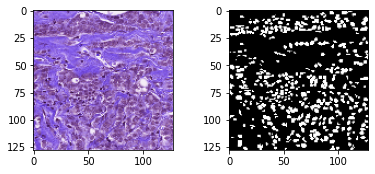

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
def DiceLoss(targets, inputs, smooth=1e-15):

    #flatten label and prediction tensors

    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(targets *inputs)

    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

    return 1 - dice

In [ ]:
model = UNet()
model1 = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model1.compile(optimizer="adam", loss= DiceLoss, metrics=["acc"])

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs)

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model1.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs)

In [ ]:
## Save the Weights
model1.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = model1.predict(x)

result = result > 0.5

1/1 [==============================] - 0s 191ms/step


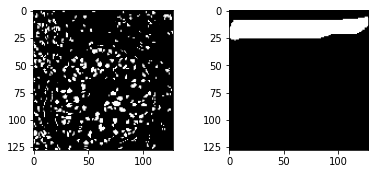

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

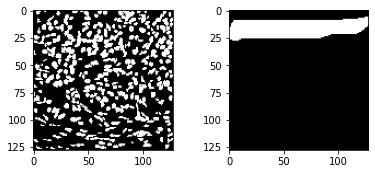

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

# Modify this basline architecture


a)Number of blocks in Unet

In [ ]:
def UNetNew():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16

    bn = bottleneck(p3, f[3])

    u2 = up_block(bn, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
modelNew = UNetNew()
modelNew1 = UNetNew()
modelNew.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
modelNew1.compile(optimizer="adam", loss= DiceLoss, metrics=["acc"])

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

modelNew1.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs)

In [ ]:
## Save the Weights
modelNew1.save_weights("UNetW.new5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = modelNew1.predict(x)

result = result > 0.5

1/1 [==============================] - 0s 145ms/step


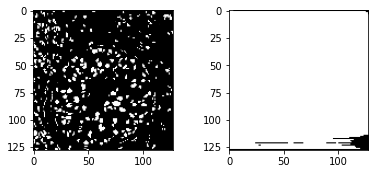

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

modelNew1.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs)

b)Number of filters per layer in the U

In [ ]:
def down_block1(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block1(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck1(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [8, 32, 128, 512, 2048]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
modelNewFilter = UNetNew()
modelNew1Filter = UNetNew()
modelNewFilter.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
modelNew1Filter.compile(optimizer="adam", loss= DiceLoss, metrics=["acc"])

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

modelNew1Filter.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
7/7 [==============================] - 3s 301ms/step - loss: 0.7388 - acc: 0.4907 - val_loss: 0.4720 - val_acc: 0.2361
Epoch 2/25
7/7 [==============================] - 1s 94ms/step - loss: 0.3927 - acc: 0.2668 - val_loss: 0.4366 - val_acc: 0.2530
Epoch 3/25
7/7 [==============================] - 1s 96ms/step - loss: 0.4952 - acc: 0.2205 - val_loss: 0.4351 - val_acc: 0.2530
Epoch 4/25
7/7 [==============================] - 1s 94ms/step - loss: 0.4454 - acc: 0.2455 - val_loss: 0.4322 - val_acc: 0.2530
Epoch 5/25
7/7 [==============================] - 1s 94ms/step - loss: 0.4272 - acc: 0.2534 - val_loss: 0.4275 - val_acc: 0.2530
Epoch 6/25
7/7 [==============================] - 1s 93ms/step - loss: 0.3766 - acc: 0.2729 - val_loss: 0.4210 - val_acc: 0.2530
Epoch 7/25
7/7 [==============================] - 1s 92ms/step - loss: 0.4471 - acc: 0.2394 - val_loss: 0.4106 - val_acc: 0.2530
Epoch 8/25
7/7 [==============================] - 1s 94ms/step - loss: 0.4447 - acc: 0.2407 - va

In [ ]:
## Save the Weights
modelNewFilter.save_weights("UNetW.new5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = modelNewFilter.predict(x)

result = result > 0.5

1/1 [==============================] - 0s 142ms/step


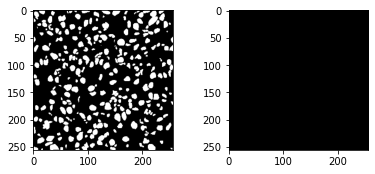

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")


c) Loss function as a combination of Dice and MS-SSIM with tradeoff parameter

In [ ]:
def Dice_MSSIM(y_pred, y_true):
  inputs = K.flatten(inputs)
  targets = K.flatten(targets)
  smooth = 1e-6

  intersection = K.sum(targets *inputs)
  dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

  MSSIM = 1
  lamda = 0.2

  return (dice + lamda*(MSSIM))


#Watershed segmentation
